In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.impute import SimpleImputer
from yellowbrick.cluster import KElbowVisualizer

pd.set_option('display.max_row', 30)
pd.set_option('display.max_column', 30)

### 투수 데이터

In [2]:
df = pd.read_csv('p_2023_00.csv', encoding='cp949')
df.head(3)

,이름,연도,팀명,출장,완투,완봉,선발,승,패,세,홀드,이닝,실점,자책,타자,안타,홈런,볼넷,고4,사구,삼진,보크,폭투,ERA,FIP,WHIP,ERA+,FIP+,WAR
0,김민범,2,현,15,0,0,0,0,0,0,1,10.0,0,0,34,5,0,0,0,1,5,0,0,0.0,2.30,0.50,NaN,185.6,0.46
1,김이슬,8,롯,13,0,0,0,0,0,0,3,8.0,1,0,31,4,0,1,0,2,5,0,1,0.0,3.02,0.63,NaN,133.2,0.32
2,허준혁,12,롯,5,0,0,1,0,0,0,0,7.2,0,0,27,4,0,2,0,0,2,0,0,0.0,3.36,0.78,NaN,113.9,0.32


In [3]:
df_sorted = df
df_sorted = df_sorted[df_sorted.duplicated(subset=['이름'], keep=False)]   # 2회 이상 이름이 나온 경우만
df_sorted = df_sorted.sort_values(by=['이름','연도']).reset_index(drop=True)

result1 = df_sorted.groupby('이름').head(2)  
result1 = result1.reset_index(drop=True)

a1 = result1.groupby('이름').head(1).reset_index(drop=True)
a2 = result1.groupby('이름').tail(1).reset_index(drop=True)

y1 = a1[a1["연도"]+1 == a2["연도"]].reset_index(drop=True)  #1년차
y2 = a2[a1["연도"]+1 == a2["연도"]].reset_index(drop=True)  #2년차

y1 = y1[y1["연도"]>9]
y2 = y2[y2["연도"]>10]

# 신인왕
rc = y1[y1['이름'].isin(['양의지','고원준','이재곤','오지환','배영섭','임찬규','서건창','박지훈','최성훈','이지영','이재학','유희관','나성범','박민우','조상우','박해민','구자욱','김하성','조무근','신재영','주권','박주현','박진형','이천웅','이정후','김원중','정현','최원준','김명신','강백호','김혜성','양창섭','구승민','박상원','정우영','이창진','전상현','김태진','원태인','소형준','홍창기','송명기','이민호','김지찬','이의리','최준용','장지훈','문보경','오원석','정철원','김인환','황성빈','박영현','김도영','문동주','윤영철','최지민','윤동희','김동헌'])]
rc = rc.sort_values(by=['연도']).reset_index(drop=True)

In [5]:
# 신인왕 후보 평균보다 WAR가 큰 선수들만 뽑기
y11 = y1[(y1["WAR"] > rc["WAR"].sum()/len(rc))]
y11 = y11.sort_values(by=['연도']).reset_index(drop=True)
y11 = y11.drop([3,4,5,6,7,8,9,10,13,16,17,18,20,22,23,26,27,29,31,32,33,34,35,37,39,41,43,44,45,46,47,48,50,51,52,53,54,55,56,58,62,64,65,67,68,72,74,75,76,77],axis=0).reset_index(drop=True)   # 외국인 제거
y11 = y11.sort_values(by=['연도','이름']).reset_index(drop=True)
y11.head(3)   # 1년차

,이름,연도,팀명,출장,완투,완봉,선발,승,패,세,홀드,이닝,실점,자책,타자,안타,홈런,볼넷,고4,사구,삼진,보크,폭투,ERA,FIP,WHIP,ERA+,FIP+,WAR
0,고원준,10,넥,30,0,0,22,5,7,0,0,131.0,64,60,570,123,15,61,0,12,87,0,8,4.12,5.12,1.41,110.3,88.8,2.21
1,김수완,10,롯,13,1,1,10,5,2,0,0,63.2,32,28,266,61,9,16,1,5,44,0,4,3.96,4.68,1.21,116.9,98.7,1.24
2,이재곤,10,롯,22,1,0,19,8,3,0,0,124.0,63,57,514,126,11,31,0,10,44,0,0,4.14,4.72,1.27,111.8,98.0,2.35


In [6]:
y22 = y2[y2['이름'].isin(y11["이름"])].sort_values(by=['연도']).reset_index(drop=True)
y22 = y22.sort_values(by=['연도','이름']).reset_index(drop=True)
y22.head(3)   # 2년차

,이름,연도,팀명,출장,완투,완봉,선발,승,패,세,홀드,이닝,실점,자책,타자,안타,홈런,볼넷,고4,사구,삼진,보크,폭투,ERA,FIP,WHIP,ERA+,FIP+,WAR
0,고원준,11,롯,36,3,2,22,9,7,2,0,152.2,77,71,670,163,15,59,1,6,85,0,10,4.19,4.61,1.45,100.2,91.0,2.34
1,김수완,11,롯,24,0,0,2,0,3,0,1,35.0,29,26,166,46,2,17,2,1,29,1,3,6.69,3.65,1.80,62.8,115.0,0.24
2,이재곤,11,롯,39,0,0,7,3,5,1,2,56.2,52,40,262,74,9,25,2,5,16,0,2,6.35,6.17,1.75,66.0,68.0,-0.68


In [7]:
print(len(y11))
print(len(y22))

28
28


#### plot

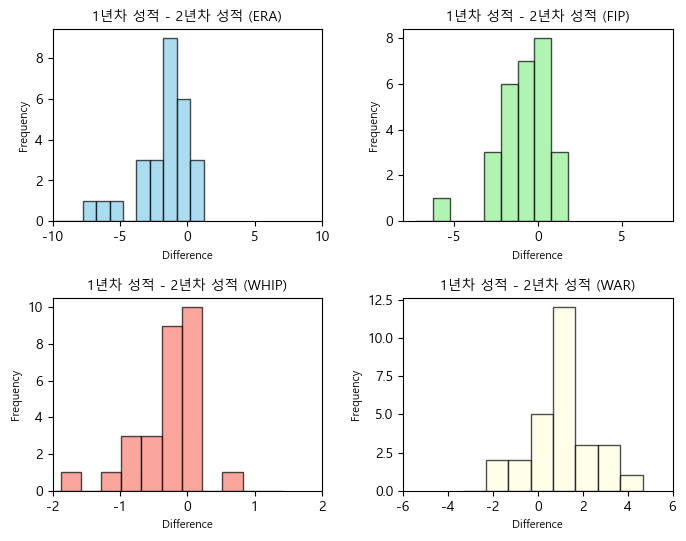

In [8]:
plt.figure(figsize=(8,6))

plt.subplot(2, 2, 1)
difference_era = y11["ERA"] - y22["ERA"]
bins_era = np.arange(min(difference_era) - 1, max(difference_era) + 1, 1)
plt.hist(difference_era, bins=bins_era, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('1년차 성적 - 2년차 성적 (ERA)', fontsize=10)
plt.xlabel('Difference', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.xlim(-10,10)

plt.subplot(2, 2, 2)
difference_fip = y11["FIP"] - y22["FIP"]
bins_fip = np.arange(min(difference_fip) - 1, max(difference_fip) + 1, 1)
plt.hist(difference_fip, bins=bins_fip, edgecolor='black', alpha=0.7, color='lightgreen')
plt.title('1년차 성적 - 2년차 성적 (FIP)', fontsize=10)
plt.xlabel('Difference', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.xlim(-8,8)

plt.subplot(2, 2, 3)
difference_whip = y11["WHIP"] - y22["WHIP"]
bins_whip = np.arange(min(difference_whip) - 1, max(difference_whip) + 1, 0.3)
plt.hist(difference_whip, bins=bins_whip, edgecolor='black', alpha=0.7, color='salmon')
plt.title('1년차 성적 - 2년차 성적 (WHIP)', fontsize=10)
plt.xlabel('Difference', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.xlim(-2,2)

plt.subplot(2, 2, 4)
difference_war = y11["WAR"] - y22["WAR"]
bins_war = np.arange(min(difference_war) - 1, max(difference_war) + 1, 1)
plt.hist(difference_war, bins=bins_war, edgecolor='black', alpha=0.7, color='lightyellow')
plt.title('1년차 성적 - 2년차 성적 (WAR)', fontsize=10)
plt.xlabel('Difference', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.xlim(-6,6)

plt.subplots_adjust(wspace=0.3,hspace=0.4)
plt.show()

#### kmeans

In [14]:
result_data = {}
for col in y22[["ERA","FIP","WHIP"]].columns:
    if col in y22[["ERA","FIP","WHIP"]].columns:
        result_data[col] = y22[col] / y11[col]

result = pd.DataFrame(result_data)
result = pd.concat([y22[["이름","팀명"]], result], axis=1)
result.head()

,이름,팀명,ERA,FIP,WHIP
0,고원준,롯,1.012077,0.976695,1.141732
1,이재곤,롯,1.541262,1.205078,1.241135
2,김수완,롯,1.689394,0.779915,1.487603
3,한현희,넥,0.949704,1.073810,0.949640
4,심창민,삼,1.464481,1.307692,0.981651


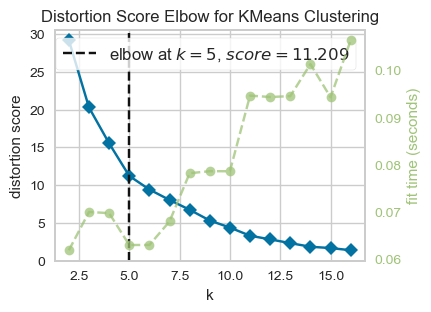

In [17]:
plt.figure(figsize=(4,3))
kmeans = KMeans(random_state=42, n_init=10)
elbow = KElbowVisualizer(kmeans,k=(2,17))
elbow.fit(res_val_scaled)
elbow.show()
plt.show()

In [16]:
result1 = result
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(res_val_scaled)

result1["kmeans"] = kmeans.labels_
result1["kmeans"] = result1["kmeans"].astype('category')
result1.head()

,이름,팀명,ERA,FIP,WHIP,kmeans
0,고원준,롯,1.012077,0.976695,1.141732,2
1,이재곤,롯,1.541262,1.205078,1.241135,1
2,김수완,롯,1.689394,0.779915,1.487603,0
3,한현희,넥,0.949704,1.073810,0.949640,2
4,심창민,삼,1.464481,1.307692,0.981651,1


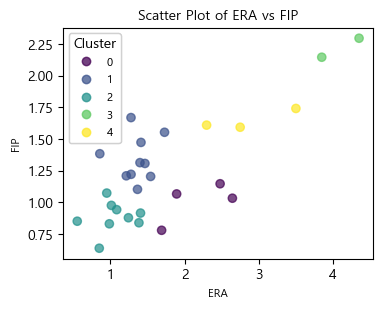

In [17]:
plt.figure(figsize=(4,3))

scatter = plt.scatter(result1['ERA'], result1['FIP'], c=result1["kmeans"], cmap='viridis', alpha=0.7)
plt.xlabel('ERA', fontsize=8)
plt.ylabel('FIP', fontsize=8)
plt.title('Scatter Plot of ERA vs FIP', fontsize=10)

legend1 = plt.legend(*scatter.legend_elements(), title="Cluster", fontsize=8)
plt.gca().add_artist(legend1)
plt.show()

#### result

In [18]:
# 징크스 O
result1[(result1["kmeans"]==3) | (result1["kmeans"]==4)]["이름"]

5     변진수
6     박지훈
8     백인식
11    조무근
17    하재훈
Name: 이름, dtype: object

In [19]:
# 징크스 X
result1[result1["kmeans"]==2]["이름"]

0     고원준
3     한현희
10    류제국
15    신재영
19    강재민
21    소형준
22    윤중현
24    이의리
25    박영현
Name: 이름, dtype: object

- 테이블

In [20]:
j1 = y11[y11['이름'].isin(["박지훈","변진수","백인식","조무근","하재훈"])][["이름","팀명"]].reset_index(drop=True)
d1 = y11[y11['이름'].isin(["박지훈","변진수","백인식","조무근","하재훈"])][["연도"]].reset_index(drop=True)
d2 = y22[y22['이름'].isin(["박지훈","변진수","백인식","조무근","하재훈"])][["연도"]].reset_index(drop=True)

j1 = pd.concat([j1,d1,d2],axis=1)
j1.columns = ["이름","팀명","1년차","2년차"]
j1

,이름,팀명,1년차,2년차
0,박지훈,K,12,13
1,변진수,두,12,13
2,백인식,S,13,14
3,조무근,k,15,16
4,하재훈,S,19,20


In [21]:
j2 = y11[y11['이름'].isin(["고원준","한현희","강재민","이의리","박영현"])][["이름","팀명"]].reset_index(drop=True)
d1 = y11[y11['이름'].isin(["고원준","한현희","강재민","이의리","박영현"])][["연도"]].reset_index(drop=True)
d2 = y22[y22['이름'].isin(["고원준","한현희","강재민","이의리","박영현"])][["연도"]].reset_index(drop=True)

j2 = pd.concat([j2,d1,d2],axis=1)
j2.columns = ["이름","팀명","1년차","2년차"]
j2

,이름,팀명,1년차,2년차
0,고원준,넥,10,11
1,한현희,넥,12,13
2,강재민,한,20,21
3,이의리,K,21,22
4,박영현,K,22,23


### 타자 데이터

In [22]:
df2 = pd.read_csv('b_2023_00.csv', encoding='cp949')
df2.head(3)

,이름,연도,포지션,G,PA,ePA,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HP,IB,SO,GDP,SH,SF,AVG,OBP,SLG,OPS,R/ePA,wRC+,WAR
0,테임즈,15,1B,142,595,588,472,130,180,42,5,47,373,140,40,8,103,13,11,91,7,0,7,0.381,0.497,0.79,1.287,0.155,218.2,11.04
1,로하스,20,RF,142,628,625,550,116,192,39,1,47,374,135,0,1,65,5,5,132,11,0,8,0.349,0.417,0.68,1.097,0.111,187.2,9.40
2,심정수,3,RF,133,601,584,460,110,154,16,1,53,331,142,6,2,124,9,17,63,14,0,8,0.335,0.478,0.72,1.198,0.130,207.3,8.98


In [23]:
df_sorted = df2
df_sorted = df_sorted[df_sorted.duplicated(subset=['이름'], keep=False)]   # 2회 이상 이름이 나온 경우만
df_sorted = df_sorted.sort_values(by=['이름','연도']).reset_index(drop=True)

result1 = df_sorted.groupby('이름').head(2)  
result1 = result1.reset_index(drop=True)

a1 = result1.groupby('이름').head(1).reset_index(drop=True)
a2 = result1.groupby('이름').tail(1).reset_index(drop=True)

y1 = a1[a1["연도"]+1 == a2["연도"]].reset_index(drop=True)  #1년차
y2 = a2[a1["연도"]+1 == a2["연도"]].reset_index(drop=True)  #2년차

# 연도 설정
y1 = y1[y1["연도"]>9]
y2 = y2[y2["연도"]>10]

# 신인왕
rc = y1[y1['이름'].isin(['양의지','고원준','이재곤','오지환','배영섭','임찬규','서건창','박지훈','최성훈','이지영','이재학','유희관','나성범','박민우','조상우','박해민','구자욱','김하성','조무근','신재영','주권','박주현','박진형','이천웅','이정후','김원중','정현','최원준','김명신','강백호','김혜성','양창섭','구승민','박상원','정우영','이창진','전상현','김태진','원태인','소형준','홍창기','송명기','이민호','김지찬','이의리','최준용','장지훈','문보경','오원석','정철원','김인환','황성빈','박영현','김도영','문동주','윤영철','최지민','윤동희','김동헌'])]
rc = rc.sort_values(by=['연도']).reset_index(drop=True)

In [25]:
# 신인왕 후보 평균보다 WAR가 큰 선수들만 뽑기
y11 = y1[(y1["WAR"] > rc["WAR"].sum()/len(rc))]
y11 = y11.sort_values(by=['연도']).reset_index(drop=True)
y11 = y11.drop([3,4,6,7,9,10,14,15,16,18,19,21,22,23,24,25,29,30,31,35,36,37,42,45,46,48],axis=0).reset_index(drop=True)  # 외국인 제거
y11.head(3)   # 1년차

,이름,연도,포지션,G,PA,ePA,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HP,IB,SO,GDP,SH,SF,AVG,OBP,SLG,OPS,R/ePA,wRC+,WAR
0,윤요섭,12,C,75,196,194,171,17,51,7,0,2,64,19,3,2,16,6,1,35,9,1,2,0.298,0.374,0.374,0.748,0.013,117.7,1.03
1,권희동,13,LF,121,397,390,349,42,71,19,1,15,137,54,4,1,36,2,0,75,6,7,3,0.203,0.279,0.393,0.672,-0.045,66.0,1.01
2,나성범,13,RF,104,458,456,404,55,98,18,5,14,168,64,12,2,33,15,3,95,7,0,6,0.243,0.319,0.416,0.735,-0.005,98.6,2.98


In [26]:
y22 = y2[y2['이름'].isin(y11["이름"])].sort_values(by=['연도']).reset_index(drop=True)
y22.head(3)   # 2년차

,이름,연도,포지션,G,PA,ePA,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HP,IB,SO,GDP,SH,SF,AVG,OBP,SLG,OPS,R/ePA,wRC+,WAR
0,윤요섭,13,C,89,228,219,186,20,38,8,1,1,51,30,2,3,23,6,0,32,6,9,4,0.204,0.306,0.274,0.580,-0.052,60.6,0.35
1,권희동,14,LF,101,252,250,221,39,63,10,2,7,98,36,6,1,25,3,2,43,4,1,2,0.285,0.363,0.443,0.806,-0.008,96.7,0.74
2,나성범,14,RF,123,536,534,477,88,157,28,5,30,285,101,14,5,42,15,2,128,4,1,1,0.329,0.400,0.597,0.997,0.064,148.0,7.00


In [27]:
print(len(y11))
print(len(y22))

23
23


#### plot

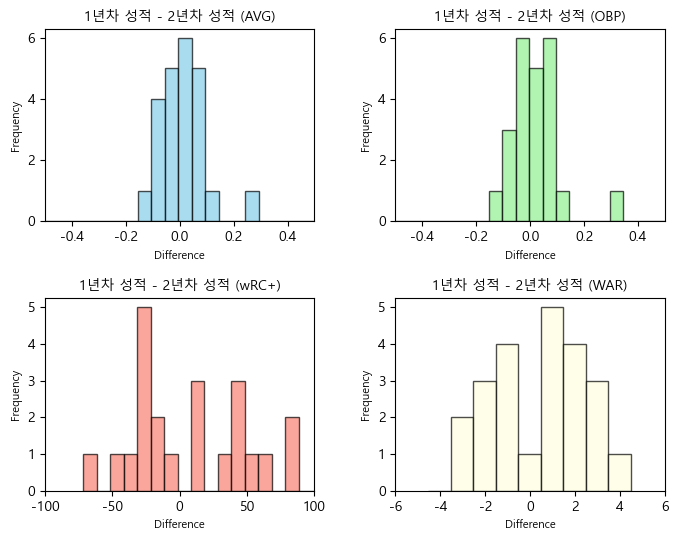

In [28]:
plt.figure(figsize=(8,6))

plt.subplot(2, 2, 1)
difference_era = y11["AVG"] - y22["AVG"]
bins_era = np.arange(min(difference_era) - 1, max(difference_era) + 1, 0.05)
plt.hist(difference_era, bins=bins_era, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('1년차 성적 - 2년차 성적 (AVG)', fontsize=10)
plt.xlabel('Difference', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.xlim(-0.5,0.5)

plt.subplot(2, 2, 2)
difference_fip = y11["OBP"] - y22["OBP"]
bins_fip = np.arange(min(difference_fip) - 1, max(difference_fip) + 1, 0.05)
plt.hist(difference_fip, bins=bins_fip, edgecolor='black', alpha=0.7, color='lightgreen')
plt.title('1년차 성적 - 2년차 성적 (OBP)', fontsize=10)
plt.xlabel('Difference', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.xlim(-0.5,0.5)

plt.subplot(2, 2, 3)
difference_whip = y11["wRC+"] - y22["wRC+"]
bins_whip = np.arange(min(difference_whip) - 1, max(difference_whip) + 1, 10)
plt.hist(difference_whip, bins=bins_whip, edgecolor='black', alpha=0.7, color='salmon')
plt.title('1년차 성적 - 2년차 성적 (wRC+)', fontsize=10)
plt.xlabel('Difference', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.xlim(-100,100)

plt.subplot(2, 2, 4)
difference_war = y11["WAR"] - y22["WAR"]
bins_war = np.arange(min(difference_war) - 1, max(difference_war) + 1, 1)
plt.hist(difference_war, bins=bins_war, edgecolor='black', alpha=0.7, color='lightyellow')
plt.title('1년차 성적 - 2년차 성적 (WAR)', fontsize=10)
plt.xlabel('Difference', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.xlim(-6,6)

plt.subplots_adjust(wspace=0.3,hspace=0.4)
plt.show()

#### kmeans

In [29]:
result_data = {}
for col in y22[["AVG","OPS","wRC+"]].columns:
    if col in y22[["AVG","OPS","wRC+"]].columns:
        result_data[col] = y22[col] / y11[col]

result = pd.DataFrame(result_data)
result = pd.concat([y22[["이름","포지션"]], result], axis=1)
result.head()

,이름,포지션,AVG,OPS,wRC+
0,윤요섭,C,0.684564,0.775401,0.514868
1,권희동,LF,1.403941,1.199405,1.465152
2,나성범,RF,1.353909,1.356463,1.501014
3,박해민,CF,0.986532,0.966622,0.930540
4,구자욱,1B,1.511013,1.496904,2.189504


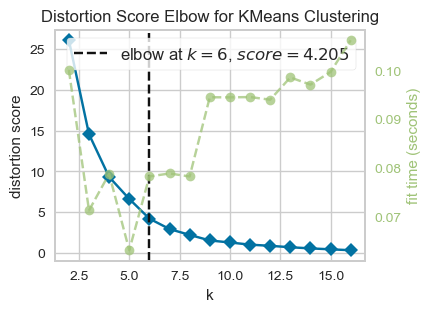

In [41]:
plt.figure(figsize=(4,3))
kmeans = KMeans(random_state=42, n_init=10)
elbow = KElbowVisualizer(kmeans,k=(2,17))
elbow.fit(res_val_scaled)
elbow.show()
plt.show()

In [31]:
result1 = result
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans.fit(res_val_scaled)

result1["kmeans"] = kmeans.labels_
result1["kmeans"] = result1["kmeans"].astype('category')
result1.head()

,이름,포지션,AVG,OPS,wRC+,kmeans
0,윤요섭,C,0.684564,0.775401,0.514868,1
1,권희동,LF,1.403941,1.199405,1.465152,0
2,나성범,RF,1.353909,1.356463,1.501014,0
3,박해민,CF,0.986532,0.966622,0.930540,3
4,구자욱,1B,1.511013,1.496904,2.189504,4


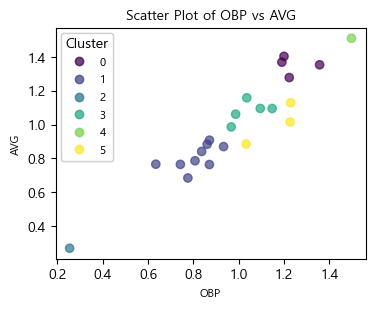

In [32]:
plt.figure(figsize=(4,3))

scatter = plt.scatter(result1['OPS'], result1['AVG'], c=result1["kmeans"], cmap='viridis', alpha=0.7)
plt.xlabel('OBP', fontsize=8)
plt.ylabel('AVG', fontsize=8)
plt.title('Scatter Plot of OBP vs AVG', fontsize=10)

legend1 = plt.legend(*scatter.legend_elements(), title="Cluster", fontsize=8)
plt.gca().add_artist(legend1)

plt.show()

#### result

In [33]:
# 징크스 O
result1[(result1["kmeans"]==2) | (result1["kmeans"]==1)]["이름"]

0     윤요섭
5     김호령
7     전민수
8     박정음
9     김성훈
11    전병우
13    이학주
18    김주원
19    지시완
20    안재석
Name: 이름, dtype: object

In [34]:
# 징크스 X
result1[(result1["kmeans"]==0) | (result1["kmeans"]==4)]["이름"]

1     권희동
2     나성범
4     구자욱
17    문보경
22    김도영
Name: 이름, dtype: object

- 테이블

In [35]:
j1 = y11[y11['이름'].isin(["전병우","전민수","박정음","이학주","안재석"])][["이름","포지션"]].reset_index(drop=True)
d1 = y11[y11['이름'].isin(["전병우","전민수","박정음","이학주","안재석"])][["연도"]].reset_index(drop=True)
d2 = y22[y22['이름'].isin(["전병우","전민수","박정음","이학주","안재석"])][["연도"]].reset_index(drop=True)

j1 = pd.concat([j1,d1,d2],axis=1)
j1.columns = ["이름","포지션","1년차","2년차"]
j1

,이름,포지션,1년차,2년차
0,전민수,RF,16,17
1,박정음,LF,16,17
2,전병우,3B,18,19
3,이학주,SS,19,20
4,안재석,2B,21,22


In [36]:
j2 = y11[y11['이름'].isin(["권희동","나성범","구자욱","문보경","김도영"])][["이름","포지션"]].reset_index(drop=True)
d1 = y11[y11['이름'].isin(["권희동","나성범","구자욱","문보경","김도영"])][["연도"]].reset_index(drop=True)
d2 = y22[y22['이름'].isin(["권희동","나성범","구자욱","문보경","김도영"])][["연도"]].reset_index(drop=True)

j2 = pd.concat([j2,d1,d2],axis=1)
j2.columns = ["이름","포지션","1년차(년도)","2년차(년도)"]
j2

,이름,포지션,1년차(년도),2년차(년도)
0,권희동,LF,13,14
1,나성범,RF,13,14
2,구자욱,1B,15,16
3,문보경,3B,21,22
4,김도영,3B,22,23
